<a href="https://colab.research.google.com/github/DungNguyenCoding/FederatedLearning/blob/main/Projects/hyperparameter_tuning_for_federated_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Hyperparameter Tuning for Federated Learning on EMNIST

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/federated/tutorials/federated_learning_for_image_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/federated/blob/v0.88.0/docs/tutorials/federated_learning_for_image_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/federated/blob/v0.88.0/docs/tutorials/federated_learning_for_image_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/federated/docs/tutorials/federated_learning_for_image_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This project focuses on hyperparameter tuning for a Federated Learning model implemented using the TensorFlow Federated (TFF) framework and the EMNIST dataset.

The core objective involves systematically experimenting with two key training parameters:
- `NUM_EPOCHS`: The number of times each client's local dataset is iterated over during a federated communication round.
- `BATCH_SIZE`: The size of the mini-batches used by clients during their local training.

Through these experiments, the project aims to observe and analyze the impact of these parameters on the model's performance (accuracy and loss) and the total training time. Results typically reveal a trade-off where configurations leading to higher accuracy (e.g., more local training and finer-grained updates) often require longer training durations. The ultimate goal is to identify an optimal balance between model effectiveness and computational efficiency

## Before we start

Before we start, please run the following to make sure that your environment is
correctly setup. If you don't see a greeting, please refer to the
[Installation](../install.md) guide for instructions.

In [ ]:
!pip uninstall -y tensorflow tensorflow-federated ml_dtypes

In [ ]:
!pip install --upgrade tensorflow tensorflow-federated

In [3]:
%load_ext tensorboard

In [ ]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

## 1. Preparing the input data

Let's start with the data. Federated learning requires a federated data set,
i.e., a collection of data from multiple users. Federated data is typically
non-[i.i.d.](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables),
which poses a unique set of challenges.

In order to facilitate experimentation, we seeded the TFF repository with a few
datasets, including a federated version of MNIST that contains a version of the [original NIST dataset](https://www.nist.gov/srd/nist-special-database-19) that has been re-processed using [Leaf](https://github.com/TalwalkarLab/leaf) so that the data is keyed by the original writer of the digits. Since each writer has a unique style, this dataset exhibits the kind of non-i.i.d. behavior expected of federated datasets.

Here's how we can load it.

In [9]:
# Load the EMNIST (Extended MNIST) train and test dataset
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

The data sets returned by `load_data()` are instances of
`tff.simulation.ClientData`, an interface that allows you to enumerate the set
of users, to construct a `tf.data.Dataset` that represents the data of a
particular user, and to query the structure of individual elements. Here's how
you can use this interface to explore the content of the data set. Keep in mind
that while this interface allows you to iterate over clients ids, this is only a
feature of the simulation data. As you will see shortly, client identities are
not used by the federated learning framework - their only purpose is to allow
you to select subsets of the data for simulations.

In [7]:
# Check the number of clients in train dataset
len(emnist_train.client_ids)

3383

In [8]:
# Check the number of clients in test dataset
len(emnist_test.client_ids)

3383

Note: The number of clients being the same does not mean they have the same data.

In [10]:
# Structure of each data sample in the dataset
emnist_train.element_type_structure

OrderedDict([('label', TensorSpec(shape=(), dtype=tf.int32, name=None)),
             ('pixels',
              TensorSpec(shape=(28, 28), dtype=tf.float32, name=None))])

In [11]:
# Get the dataset from the first client
example_dataset = emnist_train.create_tf_dataset_for_client(emnist_train.client_ids[0])

In [12]:
# Converting the first example from the client's dataset into an iterator and getting the first example from this iterator.
example_element = next(iter(example_dataset))
print(example_element.keys())

# Extract the label value
example_element['label'].numpy()

odict_keys(['label', 'pixels'])


1

**Note:**
- The EMNIST dataset contains 62 classes (digits 0-9, uppercase & lowercase letters).
- The result `1` means the first image in this client's dataset is labeled as class `1`.

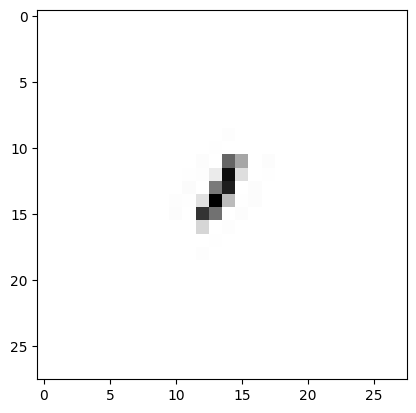

In [13]:
# Import Matplotlib for visualization
from matplotlib import pyplot as plt

# Converts the tensor into a NumPy array so Matplotlib can display it.
# Displays the image in grayscale (since EMNIST images are black-and-white).
# Ensures that the image maintains its correct proportions.
plt.imshow(example_element['pixels'].numpy(), cmap='gray', aspect='equal')

# Removes the grid for better visualization
plt.grid(False)

# Render and display the image
_ = plt.show()

### Exploring heterogeneity in federated data

Federated data is typically non-[i.i.d.](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables), users typically have different distributions of data depending on usage patterns. Some clients may have fewer training examples on device, suffering from data paucity locally, while some clients will have more than enough training examples. Let's explore this concept of data heterogeneity typical of a federated system with the EMNIST data we have available. It's important to note that this deep analysis of a client's data is only available to us because this is a simulation environment where all the data is available to us locally. In a real production federated environment you would not be able to inspect a single client's data.

First, let's grab a sampling of one client's data to get a feel for the examples on one simulated device. Because the dataset we're using has been keyed by unique writer, the data of one client represents the handwriting of one person for a sample of the digits 0 through 9, simulating the unique "usage pattern" of one user.

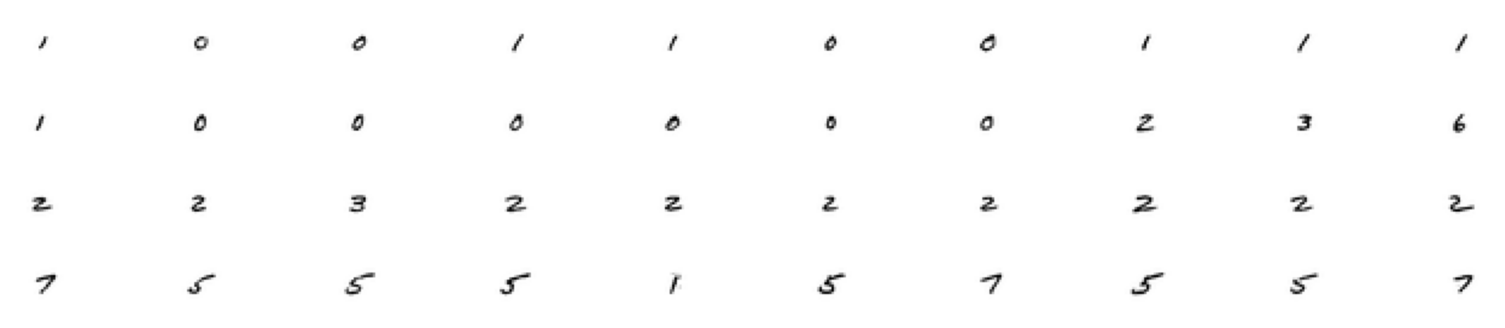

In [14]:
## Example MNIST digits from the first client

# Create a figure with a wide aspect ratio
figure = plt.figure(figsize=(20, 4))

for j, example in enumerate(example_dataset.take(40)):  # Use enumerate() for cleaner indexing
    plt.subplot(4, 10, j + 1)  # Arrange in a 4-row, 10-column grid
    plt.imshow(example['pixels'].numpy(), cmap='gray', aspect='equal')
    plt.axis('off')  # Hide axis labels

# Render and display the image
_ = plt.show()

Now let's visualize the number of examples on each client for each MNIST digit label. In the federated environment, the number of examples on each client can vary quite a bit, depending on user behavior.

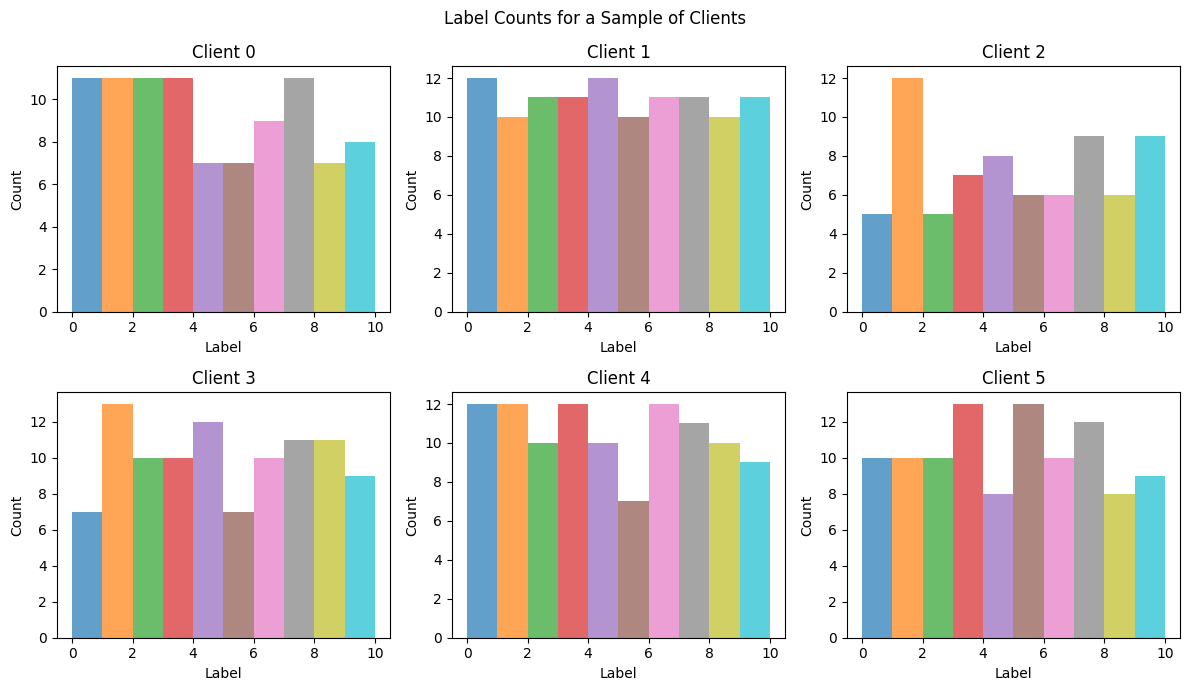

In [15]:
# Create a figure with a title
f = plt.figure(figsize=(12, 7))
f.suptitle('Label Counts for a Sample of Clients')

# Loop through 6 clients
for i in range(6):
    # Select one client
    client_dataset = emnist_train.create_tf_dataset_for_client(
        emnist_train.client_ids[i])

    # Dictionary to store label counts
    plot_data = collections.defaultdict(list)

    for example in client_dataset:
        # Extract label as an integer
        label = example['label'].numpy()
        # Append label to corresponding list
        plot_data[label].append(label)

    # Create a subplot (2 rows, 3 columns)
    plt.subplot(2, 3, i+1)
    # Title for each client's histogram
    plt.title(f'Client {i}')

    # Plot histograms for labels 0-9
    for j in range(10):
        plt.hist(plot_data[j], bins=range(11), alpha=0.7, label=str(j))

    plt.xlabel("Label")  # X-axis label
    plt.ylabel("Count")  # Y-axis label

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the figure


Now let's visualize the mean image per client for each MNIST label. This code will produce the mean of each pixel value for all of the user's examples for one label. We'll see that one client's mean image for a digit will look different than another client's mean image for the same digit, due to each person's unique handwriting style. We can muse about how each local training round will nudge the model in a different direction on each client, as we're learning from that user's own unique data in that local round. Later in the notebook we'll see how we can take each update to the model from all the clients and aggregate them together into our new global model, that has learned from each of our client's own unique data.

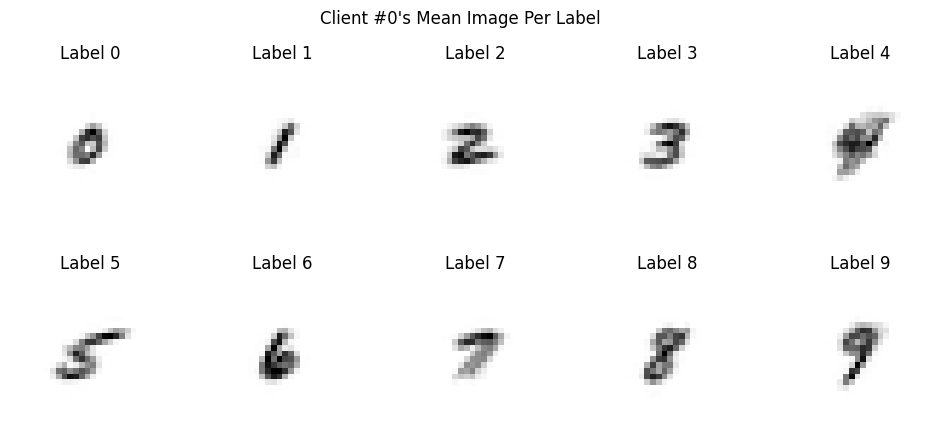

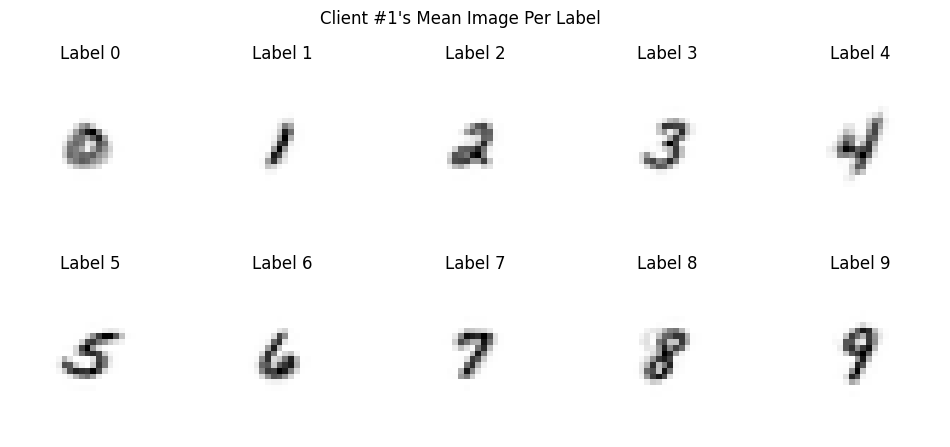

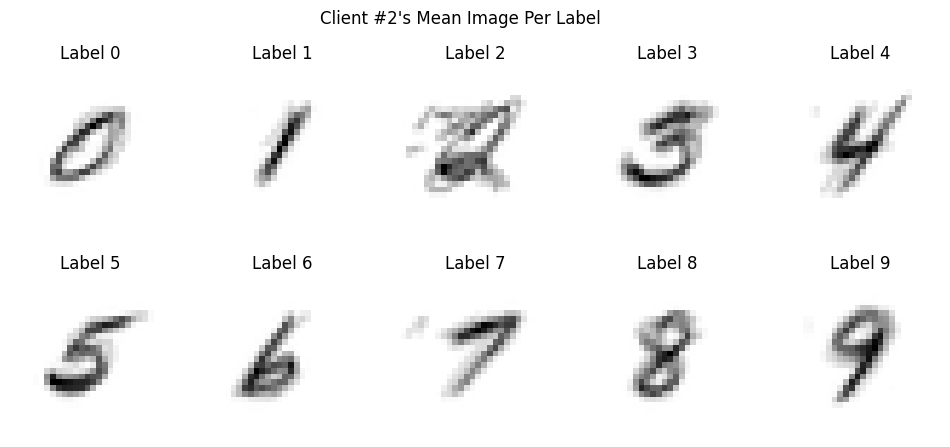

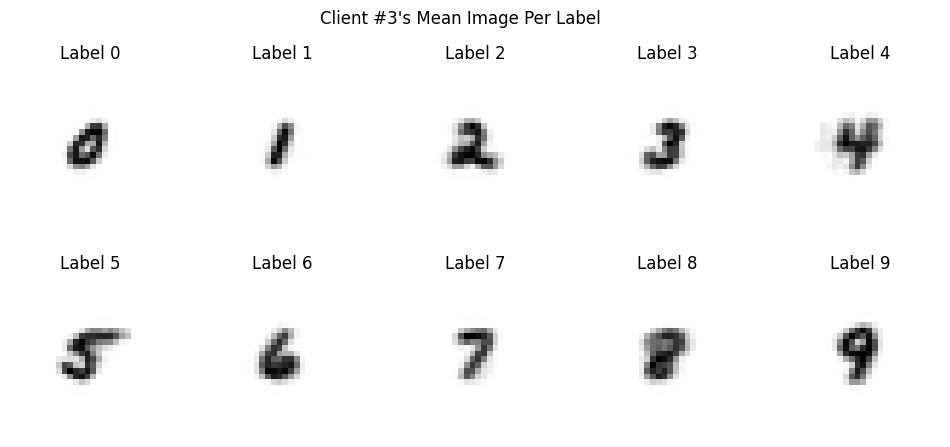

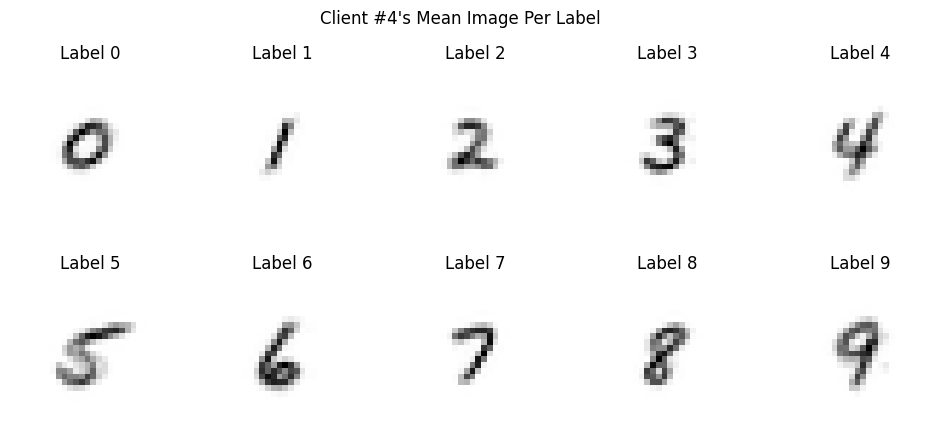

In [16]:
# Loop through 5 clients
for i in range(5):
    client_dataset = emnist_train.create_tf_dataset_for_client(
        emnist_train.client_ids[i])  # Select client dataset

    plot_data = collections.defaultdict(list)  # Dictionary to store pixel values per label

    # Collect images per label
    for example in client_dataset:
        label = example['label'].numpy()
        plot_data[label].append(example['pixels'].numpy())

    # Create a new figure for this client
    f = plt.figure(figsize=(12, 5))
    f.suptitle(f"Client #{i}'s Mean Image Per Label")  # Title with client ID

    # Loop through digits 0-9
    for j in range(10):
        if plot_data[j]:  # Ensure the label exists for this client
            mean_img = np.mean(plot_data[j], axis=0)  # Compute mean image
        else:
            mean_img = np.zeros((28, 28))  # If no samples, show blank image

        plt.subplot(2, 5, j+1)
        plt.imshow(mean_img, cmap='gray')  # Display mean image in grayscale
        plt.axis('off')  # Remove axis for clarity
        plt.title(f"Label {j}")

    plt.show()  # Display the figure


User data can be noisy and unreliably labeled. For example, looking at Client #2's data above, we can see that for label 2, it is possible that there may have been some mislabeled examples creating a noisier mean image.

### Preprocessing the input data

Since the data is already a `tf.data.Dataset`,  preprocessing can be accomplished using Dataset transformations. Here, we flatten the `28x28` images
into `784`-element arrays, shuffle the individual examples, organize them into batches, and rename the features
from `pixels` and `label` to `x` and `y` for use with Keras. We also throw in a
`repeat` over the data set to run several epochs.

In [17]:
NUM_CLIENTS = 50         # Number of clients participating in federated training
SHUFFLE_BUFFER = 100     # Buffer size for shuffling (affects randomness)
PREFETCH_BUFFER = 10     # Number of batches to prefetch for performance optimization

def preprocess(dataset, num_epochs, batch_size):

  def batch_format_fn(element):
    """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
    return collections.OrderedDict(
        x=tf.reshape(element['pixels'], [-1, 784]),
        y=tf.reshape(element['label'], [-1, 1]))

  # Use the passed parameters instead of global variables
  return dataset.repeat(num_epochs).shuffle(SHUFFLE_BUFFER, seed=1).batch(
      batch_size).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

| Transformation                      | Purpose |
|--------------------------------------|---------|
| `dataset.repeat(NUM_EPOCHS)`        | Each client repeats their dataset `NUM_EPOCHS` times to ensure multiple training iterations. |
| `dataset.shuffle(SHUFFLE_BUFFER, seed=1)` | Randomizes the order of examples to prevent the model from memorizing patterns in a specific sequence. |
| `dataset.batch(BATCH_SIZE)`         | Groups data into mini-batches of size `BATCH_SIZE`, allowing for efficient parallel processing. |
| `dataset.map(batch_format_fn)`      | Converts each batch into a structured format with `x` (flattened images) and `y` (labels). |
| `dataset.prefetch(PREFETCH_BUFFER)` | Preloads `PREFETCH_BUFFER` batches to reduce training time by ensuring data is available when needed. |


Let's verify this worked.

In [18]:
NUM_EPOCHS = 5           # Number of times each client's data is repeated during training
BATCH_SIZE = 20          # Number of examples in each batch

preprocessed_example_dataset = preprocess(example_dataset, NUM_EPOCHS, BATCH_SIZE)

sample_batch = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(preprocessed_example_dataset)))

sample_batch

OrderedDict([('x',
              array([[1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     ...,
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)),
             ('y',
              array([[2],
                     [1],
                     [5],
                     [7],
                     [1],
                     [7],
                     [7],
                     [1],
                     [4],
                     [7],
                     [4],
                     [2],
                     [2],
                     [5],
                     [4],
                     [1],
                     [1],
                     [0],
                     [0],
                     [9]], dtype=int32))])

We have almost all the building blocks in place to construct federated data
sets.

One of the ways to feed federated data to TFF in a simulation is simply as a
Python list, with each element of the list holding the data of an individual
user, whether as a list or as a `tf.data.Dataset`. Since we already have
an interface that provides the latter, let's use it.

Here's a simple helper function that will construct a list of datasets from the
given set of users as an input to a round of training or evaluation.

In [19]:
def make_federated_data(client_data, client_ids, num_epochs, batch_size):
  return [
      preprocess(client_data.create_tf_dataset_for_client(x), num_epochs, batch_size) # Pass them to preprocess
      for x in client_ids
  ]

Now, how do we choose clients?

In a typical federated training scenario, we are dealing with potentially a very
large population of user devices, only a fraction of which may be available for
training at a given point in time. This is the case, for example, when the
client devices are mobile phones that participate in training only when plugged
into a power source, off a metered network, and otherwise idle.

Of course, we are in a simulation environment, and all the data is locally
available. Typically then, when running simulations, we would simply sample a
random subset of the clients to be involved in each round of training, generally
different in each round.

That said, as you can find out by studying the paper on the
[Federated Averaging](https://arxiv.org/abs/1602.05629) algorithm, achieving convergence in a system with randomly sampled
subsets of clients in each round can take a while, and it would be impractical
to have to run hundreds of rounds in this interactive tutorial.

What we'll do instead is sample the set of clients once, and
reuse the same set across rounds to speed up convergence (intentionally
over-fitting to these few user's data). We leave it as an exercise for the
reader to modify this tutorial to simulate random sampling - it is fairly easy to
do (once you do, keep in mind that getting the model to converge may take a
while).

In [20]:
sample_clients = emnist_train.client_ids[0:NUM_CLIENTS]

federated_train_data = make_federated_data(emnist_train, sample_clients, NUM_EPOCHS, BATCH_SIZE)

print(f'Number of client datasets: {len(federated_train_data)}')
print(f'First dataset: {federated_train_data[0]}')

Number of client datasets: 50
First dataset: <_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 784), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))])>


## 2. Creating a model with Keras

If you are using Keras, you likely already have code that constructs a Keras
model. Here's an example of a simple model that will suffice for our needs.

In [21]:
def create_keras_model():
  return tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(784,)),
      tf.keras.layers.Dense(10, kernel_initializer='zeros'),
      tf.keras.layers.Softmax(),
  ])
def model_fn():
  # We _must_ create a new model here, and not capture it from an external scope.
  # TFF will call this within different graph contexts.
  keras_model = create_keras_model()
  return tff.learning.models.from_keras_model(
      keras_model,
      input_spec=preprocessed_example_dataset.element_spec,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

**What Does This Model Do?**

- Input shape = `(784,)` → Each EMNIST image (28×28) is flattened into a 1D vector of size 784.
- Dense Layer (`Dense(10)`) → Has 10 neurons, one for each digit (0-9).
- `kernel_initializer='zeros'` → Initializes weights to zero (usually not optimal, but TFF handles this differently).
- Softmax Layer (`Softmax()`) → Converts the logits (raw scores) into probabilities for classification.

**Key Points**

- No hidden layers → This is a simple model (Logistic Regression-like).
- Softmax activation → Outputs a probability distribution over 10 digits.
- Weight initialization as zeros → Not common in deep learning, but fine for federated learning.

**Note:**
In order to use any model with TFF, it needs to be wrapped in an instance of the
`tff.learning.models.VariableModel` interface, which exposes methods to stamp the model's
forward pass, metadata properties, etc., similarly to Keras, but also introduces
additional elements, such as ways to control the process of computing federated
metrics.

## 3. Training the model on federated data

Now that we have a model wrapped as `tff.learning.models.VariableModel` for use with TFF, we
can let TFF construct a Federated Averaging algorithm by invoking the helper
function `tff.learning.algorithms.build_weighted_fed_avg`, as follows.

Keep in mind that the argument needs to be a constructor (such as `model_fn`
above), not an already-constructed instance, so that the construction of your
model can happen in a context controlled by TFF

One critical note on the Federated Averaging algorithm below, there are **2**
optimizers: a _client_optimizer_ and a _server_optimizer_. The
_client_optimizer_ is only used to compute local model updates on each client.
The _server_optimizer_ applies the averaged update to the global model at the
server. In particular, this means that the choice of optimizer and learning rate
used may need to be different than the ones you have used to train the model on
a standard i.i.d. dataset.

In [22]:
training_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=tff.learning.optimizers.build_sgdm(learning_rate=0.02),
    server_optimizer_fn=tff.learning.optimizers.build_sgdm(learning_rate=1.0))

What just happened? TFF has constructed a pair of *federated computations* and
packaged them into a `tff.templates.IterativeProcess` in which these computations
are available as a pair of properties `initialize` and `next`.

**Step-by-Step Process**
1. Clients download the global model from the server.
2. Each client trains locally on its own data using SGD+Momentum (learning rate 0.02).
3. Clients send model updates (not raw data!) back to the server.
4. The server aggregates updates using Weighted FedAvg and applies them using SGD+Momentum (learning rate 1.0).
5. The updated global model is sent back to the clients for the next round.
6. Repeat for multiple training rounds until convergence.

In a nutshell, *federated computations* are programs in TFF's internal language
that can express various federated algorithms. In this
case, the two computations generated and packed into `iterative_process`
implement [Federated Averaging](https://arxiv.org/abs/1602.05629).

It is a goal of TFF to define computations in a way that they could be executed
in real federated learning settings, but currently only local execution
simulation runtime is implemented. To execute a computation in a simulator, you
simply invoke it like a Python function. This default interpreted environment is
not designed for high performance, but it will suffice for this tutorial; we
expect to provide higher-performance simulation runtimes to facilitate
larger-scale research in future releases.

Let's start with the `initialize` computation. As is the case for all federated
computations, you can think of it as a function. The computation takes no
arguments, and returns one result - the representation of the state of the
Federated Averaging process on the server. It may be instructive to see what this state looks like. You can
visualize it as follows.

In [23]:
# Get type signature of the initialize function of the training_process
print(training_process.initialize.type_signature.formatted_representation())

( -> <
  global_model_weights=<
    trainable=<
      float32[784,10],
      float32[10]
    >,
    non_trainable=<>
  >,
  distributor=<>,
  client_work=<
    learning_rate=float32
  >,
  aggregator=<
    value_sum_process=<>,
    weight_sum_process=<>
  >,
  finalizer=<
    learning_rate=float32
  >
>@SERVER)


The following table describes the components of the server state maintained during training:

| **Component**            | **Description** |
|--------------------------|----------------|
| **`global_model_weights`** | Stores the **current global model parameters** shared with clients. |
| **`trainable`**          | Trainable weights of the model: |
|                          | - `float32[784,10]` → Weights of the Dense layer (784 input features, 10 output classes). |
|                          | - `float32[10]` → Biases for the Dense layer. |
| **`non_trainable`**      | No non-trainable parameters (e.g., batch norm statistics). |
| **`distributor`**        | Placeholder for **model distribution logic** (empty in this case). |
| **`client_work`**        | Defines how clients train their models: |
|                          | - `learning_rate=float32` → The learning rate used for local training on clients. |
| **`aggregator`**         | Aggregates updates from clients using: |
|                          | - `value_sum_process=< >` → Sum of client model updates. |
|                          | - `weight_sum_process=< >` → Sum of client update weights for weighted averaging. |
| **`finalizer`**          | Applies a final learning rate adjustment: |
|                          | - `learning_rate=float32` → Learning rate applied when updating the global model. |
| **`@SERVER`**            | Indicates that all these components are stored **on the server**. |



**How Does This Relate to Training?**
- The server starts with these parameters before training begins.
- During training:
  1. **Clients receive** `global_model_weights`.
  2. Each client **trains locally** using `client_work.learning_rate`.
  3. Clients **send updates** back to the **server**.
  4. The **aggregator** computes a **weighted sum** of the updates.
  5. The **finalizer** applies `learning_rate` to adjust the global model.

While the above type signature may at first seem a bit cryptic, you can
recognize that the server state consists of a `global_model_weights` (the initial model parameters for MNIST that will be distributed to all devices), some empty parameters (like `distributor`, which governs the server-to-client communication) and a `finalizer` component. This last one governs the logic that the server uses to update its model at the end of a round, and contains an integer representing how many rounds of FedAvg have occurred.

Let's invoke the `initialize` computation to construct the server state.

In [24]:
train_state = training_process.initialize()

The second of the pair of federated computations, `next`, represents a single
round of Federated Averaging, which consists of pushing the server state
(including the model parameters) to the clients, on-device training on their
local data, collecting and averaging model updates, and producing a new updated
model at the server.

Conceptually, you can think of `next` as having a functional type signature that
looks as follows.

```
SERVER_STATE, FEDERATED_DATA -> SERVER_STATE, TRAINING_METRICS
```

In particular, one should think about `next()` not as being a function that runs on a server, but rather being a declarative functional representation of the entire decentralized computation - some of the inputs are provided by the server (`SERVER_STATE`), but each participating device contributes its own local dataset.

Let's run a single round of training and visualize the results. We can use the
federated data we've already generated above for a sample of users.

In [25]:
result = training_process.next(train_state, federated_train_data)
train_state = result.state
train_metrics = result.metrics
print('round  1, metrics={}'.format(train_metrics))

round  1, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.12501074), ('loss', 3.084638), ('num_examples', 23270), ('num_batches', 1183)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])


### Hyperparameter Tuning Implementation for Federated Learning

Now, let's implement the hyperparameter tuning process for `NUM_EPOCHS` and `BATCH_SIZE` in the Federated Learning model by picking each combination of suggested `NUM_EPOCHS` and `BATCH_SIZE` and executing training process. Then, see which combination come up with the best performance (e.g., lowest loss and highest accuracy) on the evaluation dataset after a fixed number of federated rounds

---

**Suggested Values for `BATCH_SIZE`:**

The batch size affects memory usage, the noise of the gradient estimate, and the speed of local training. Smaller batches introduce more noise, which can sometimes help generalization, while larger batches provide a more stable gradient estimate

1. `BATCH_SIZE = 16`: A relatively small batch size. This means more frequent weight updates per epoch, and often introduces more "noise" into the local gradients, which can sometimes help the model escape shallow local minima and generalize better. It's also less memory-intensive
2. `BATCH_SIZE = 32`: This is a very common default batch size in deep learning. It often provides a good balance between computational efficiency (processing data in chunks) and the stochasticity needed for effective gradient descent
3. `BATCH_SIZE = 64`: A larger batch size. This provides more stable gradient estimates and can speed up local training per epoch, as fewer updates are performed. However, it might require more memory on client devices and could sometimes lead to convergence to sharper, less generalizable minima

---

**Suggested Values for `NUM_EPOCHS`:**

The number of local epochs determines how much training each client performs on its local data before sending updates to the server

1. `NUM_EPOCHS = 1`: This is the most conservative setting. Clients make only one pass over their data. This reduces local computation time and the risk of client drift (where local models diverge too much from the global model). It often requires more communication rounds for the global model to converge

2. `NUM_EPOCHS = 3`: A moderate setting. Clients get a few passes to learn from their local data, making their updates more informed, but still keeping local computation relatively low. This is a good balance for many federated setups

3. `NUM_EPOCHS = 5`: A slightly more aggressive setting. Clients perform more local training. This can potentially lead to faster convergence of the global model in terms of communication rounds, as each round incorporates more significant local learning. However, it increases local computation time and the risk of client drift, especially with highly heterogeneous data

In [26]:
import time

NUM_ROUNDS = 100
NUM_CLIENTS = 50

# Proposed values for tuning
proposed_num_epochs = [1, 3, 5]
proposed_batch_sizes = [16, 32, 64]

# Store results for each combination
tuning_results_list = []

for current_epochs in proposed_num_epochs:
    for current_batch_size in proposed_batch_sizes:
        print(f"\n--- Starting training for NUM_EPOCHS={current_epochs}, BATCH_SIZE={current_batch_size} ---")

        # Record the start time for this combination's training
        start_time = time.time()

        train_state = training_process.initialize()

        sample_clients = emnist_train.client_ids[0:NUM_CLIENTS]
        federated_train_data = make_federated_data(emnist_train, sample_clients, current_epochs, current_batch_size)

        rounds_current_run = []
        losses_current_run = []
        accuracies_current_run = []

        for round_num in range(1, NUM_ROUNDS + 1):
            result = training_process.next(train_state, federated_train_data)
            train_state = result.state
            train_metrics = result.metrics

            train_loss = train_metrics['client_work']['train']['loss']
            try:
                train_acc = train_metrics['client_work']['train']['sparse_categorical_accuracy']
            except KeyError:
                train_acc = train_metrics['client_work']['train']['accuracy']

            rounds_current_run.append(round_num)
            losses_current_run.append(train_loss)
            accuracies_current_run.append(train_acc)

            if round_num % 10 == 0 or round_num == NUM_ROUNDS:
                print(f"  Round {round_num}/{NUM_ROUNDS}: Loss = {train_loss:.4f}, Accuracy = {train_acc:.4f}")

        # Record the end time for this combination's training
        end_time = time.time()
        total_training_time = end_time - start_time # Calculate the total time

        # Store the results for this combination as a dictionary in the list
        tuning_results_list.append({
            'num_epochs': current_epochs,
            'batch_size': current_batch_size,
            'total_training_time_seconds': total_training_time,
            'rounds': rounds_current_run,
            'losses': losses_current_run,
            'accuracies': accuracies_current_run
        })
        print(f"--- Finished training for NUM_EPOCHS={current_epochs}, BATCH_SIZE={current_batch_size} (Time: {total_training_time:.2f} seconds) ---")

# After all runs, 'tuning_results_list' will contain all training results
print("\n--- Tuning Summary (with Training Time) ---")
for result_entry in tuning_results_list:
    final_loss = result_entry['losses'][-1]
    final_accuracy = result_entry['accuracies'][-1]
    total_time = result_entry['total_training_time_seconds']
    print(f"Epochs: {result_entry['num_epochs']}, Batch: {result_entry['batch_size']}: "
          f"Final Loss = {final_loss:.4f}, Final Accuracy = {final_accuracy:.4f}, "
          f"Time = {total_time:.2f} seconds")


--- Starting training for NUM_EPOCHS=1, BATCH_SIZE=16 ---
  Round 10/100: Loss = 2.7738, Accuracy = 0.1571
  Round 20/100: Loss = 2.4941, Accuracy = 0.2469
  Round 30/100: Loss = 2.2532, Accuracy = 0.3152
  Round 40/100: Loss = 2.0493, Accuracy = 0.3668
  Round 50/100: Loss = 1.8763, Accuracy = 0.4134
  Round 60/100: Loss = 1.7291, Accuracy = 0.4575
  Round 70/100: Loss = 1.6038, Accuracy = 0.4979
  Round 80/100: Loss = 1.4971, Accuracy = 0.5352
  Round 90/100: Loss = 1.4063, Accuracy = 0.5662
  Round 100/100: Loss = 1.3288, Accuracy = 0.5967
--- Finished training for NUM_EPOCHS=1, BATCH_SIZE=16 (Time: 392.79 seconds) ---

--- Starting training for NUM_EPOCHS=1, BATCH_SIZE=32 ---
  Round 10/100: Loss = 2.4158, Accuracy = 0.1637
  Round 20/100: Loss = 2.2680, Accuracy = 0.2793
  Round 30/100: Loss = 2.1337, Accuracy = 0.3477
  Round 40/100: Loss = 2.0123, Accuracy = 0.3949
  Round 50/100: Loss = 1.9029, Accuracy = 0.4295
  Round 60/100: Loss = 1.8048, Accuracy = 0.4633
  Round 70/100: 

---
After the training process, let's add some graphics to illustrate the results

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker

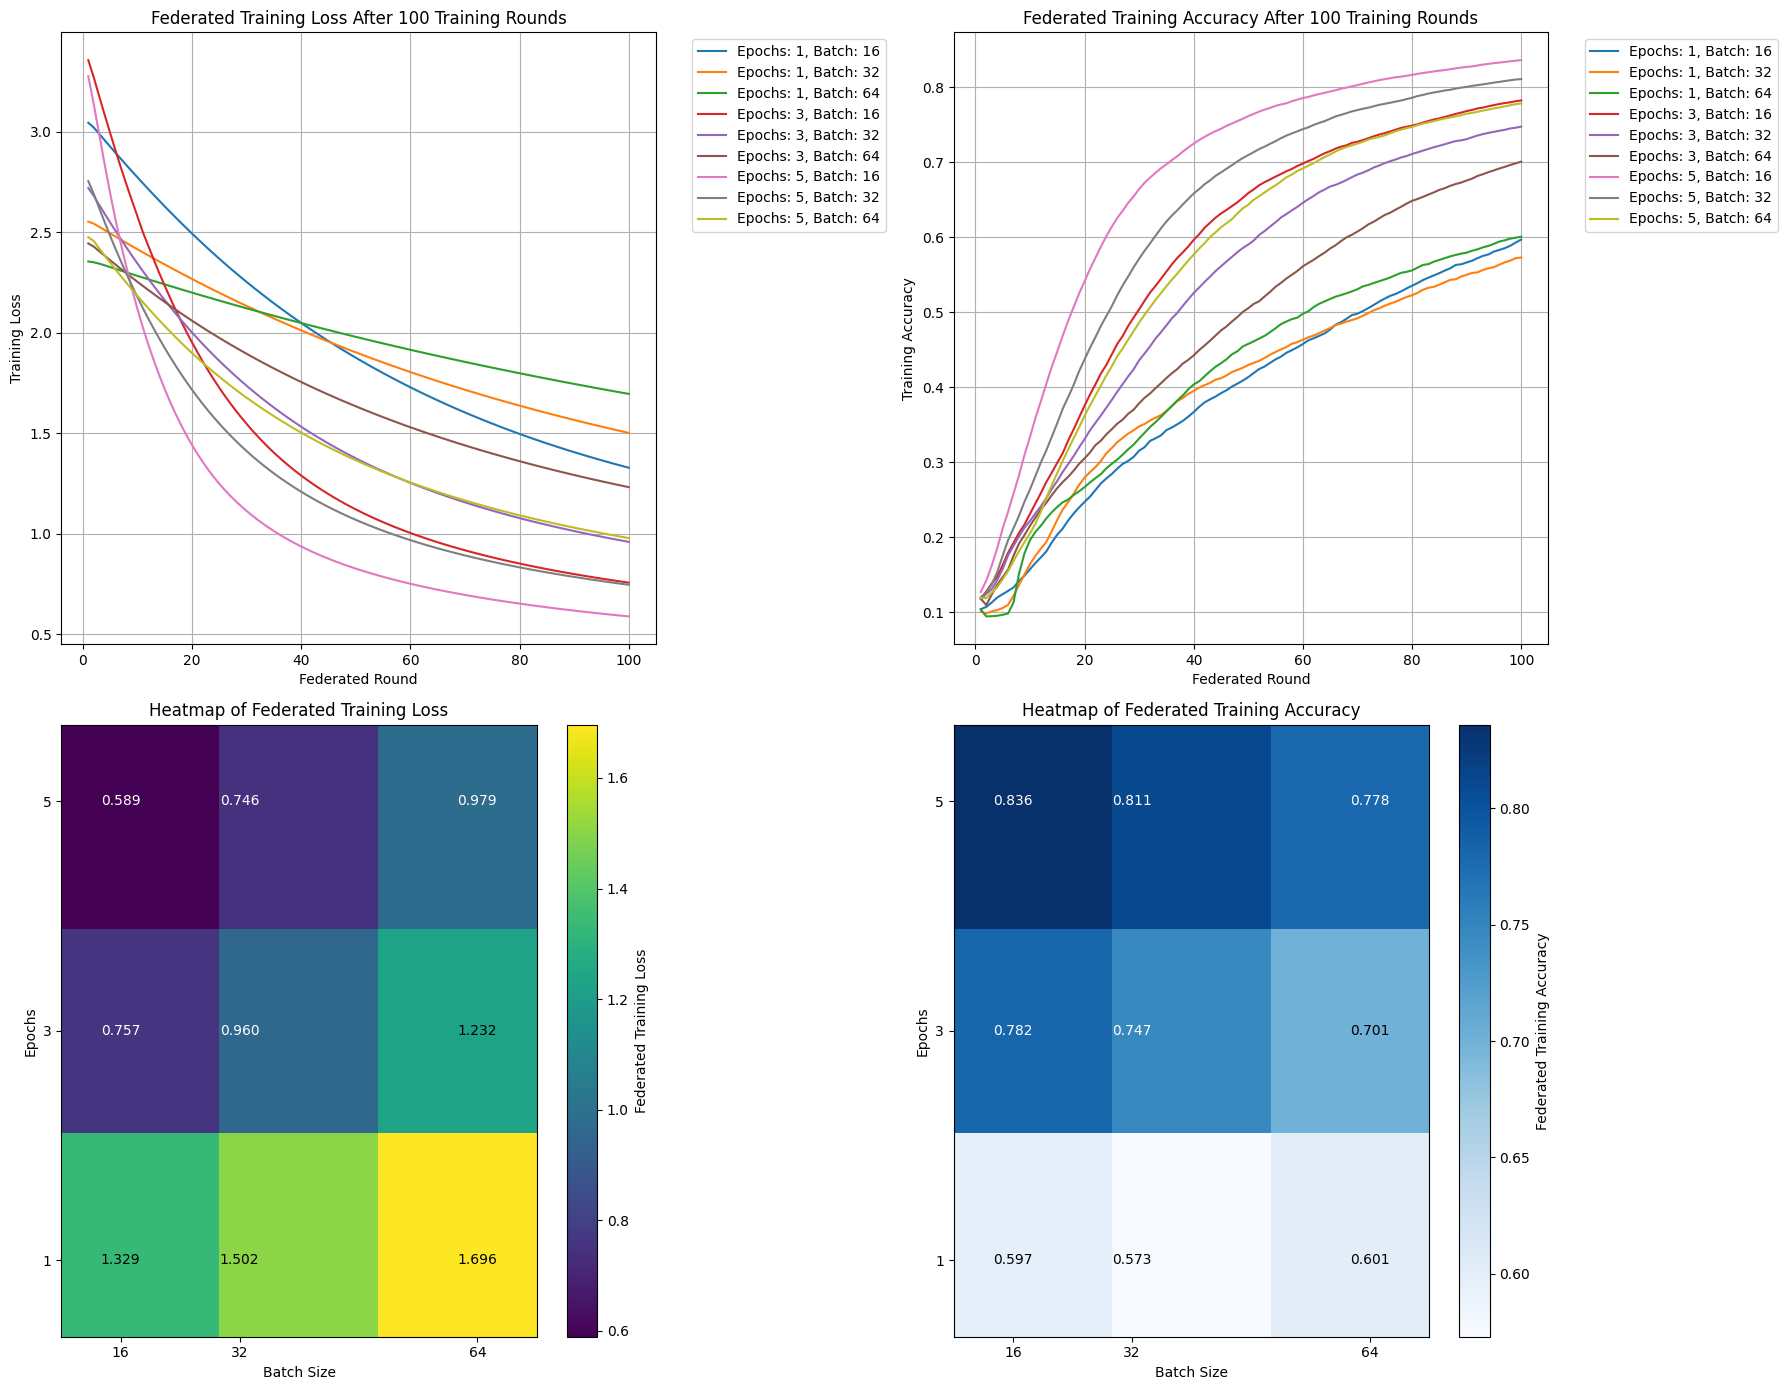

In [57]:
# --- Create a 2x2 grid of subplots for Loss, Accuracy, and Heatmaps ---
fig, axes = plt.subplots(2, 2, figsize=(18, 14)) # Create a 2x2 grid of subplots
axes = axes.flatten() # Flatten the 2x2 array of axes for easier iteration

# --- Federated Training Loss of all combinations ---
ax1 = axes[0]
for result_entry in tuning_results_list:
    label = f"Epochs: {result_entry['num_epochs']}, Batch: {result_entry['batch_size']}"
    ax1.plot(result_entry['rounds'], result_entry['losses'], label=label)

ax1.set_xlabel('Federated Round')
ax1.set_ylabel('Training Loss')
ax1.set_title('Federated Training Loss After 100 Training Rounds')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True)

# --- Federated Training Accuracy of all combinations ---
ax2 = axes[1]
for result_entry in tuning_results_list:
    label = f"Epochs: {result_entry['num_epochs']}, Batch: {result_entry['batch_size']}"
    ax2.plot(result_entry['rounds'], result_entry['accuracies'], label=label)

ax2.set_xlabel('Federated Round')
ax2.set_ylabel('Training Accuracy')
ax2.set_title('Federated Training Accuracy After 100 Training Rounds')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True)

# --- Prepare data for Heatmaps ---
num_epochs_values = sorted(list(set([r['num_epochs'] for r in tuning_results_list])))
batch_size_values = sorted(list(set([r['batch_size'] for r in tuning_results_list])))

final_losses_matrix = np.zeros((len(num_epochs_values), len(batch_size_values)))
final_accuracies_matrix = np.zeros((len(num_epochs_values), len(batch_size_values)))

for result_entry in tuning_results_list:
    epochs_idx = num_epochs_values.index(result_entry['num_epochs'])
    batch_idx = batch_size_values.index(result_entry['batch_size'])
    final_losses_matrix[epochs_idx, batch_idx] = result_entry['losses'][-1]
    final_accuracies_matrix[epochs_idx, batch_idx] = result_entry['accuracies'][-1]

# --- Heatmap of Federated Training Loss ---
ax3 = axes[2]
im3 = ax3.imshow(final_losses_matrix, cmap='viridis', origin='lower',
           extent=[min(batch_size_values) - (max(batch_size_values) - min(batch_size_values))/6,
                   max(batch_size_values) + (max(batch_size_values) - min(batch_size_values))/6,
                   min(num_epochs_values) - (max(num_epochs_values) - min(num_epochs_values))/6,
                   max(num_epochs_values) + (max(num_epochs_values) - min(num_epochs_values))/6],
           aspect='auto')
fig.colorbar(im3, ax=ax3, label='Federated Training Loss')
ax3.set_xticks(batch_size_values, labels=[str(bs) for bs in batch_size_values])
ax3.set_yticks(num_epochs_values, labels=[str(ne) for ne in num_epochs_values])
ax3.set_xlabel('Batch Size')
ax3.set_ylabel('Epochs')
ax3.set_title('Heatmap of Federated Training Loss')
for (j, i), val in np.ndenumerate(final_losses_matrix):
    ax3.text(batch_size_values[i], num_epochs_values[j], f'{val:.3f}', ha='center', va='center',
             color='white' if val < np.mean(final_losses_matrix) else 'black')

# --- Heatmap of Federated Training Accuracy  ---
ax4 = axes[3]
im4 = ax4.imshow(final_accuracies_matrix, cmap='Blues', origin='lower',
           extent=[min(batch_size_values) - (max(batch_size_values) - min(batch_size_values))/6,
                   max(batch_size_values) + (max(batch_size_values) - min(batch_size_values))/6,
                   min(num_epochs_values) - (max(num_epochs_values) - min(num_epochs_values))/6,
                   max(num_epochs_values) + (max(num_epochs_values) - min(num_epochs_values))/6],
           aspect='auto')
fig.colorbar(im4, ax=ax4, label='Federated Training Accuracy')
ax4.set_xticks(batch_size_values, labels=[str(bs) for bs in batch_size_values])
ax4.set_yticks(num_epochs_values, labels=[str(ne) for ne in num_epochs_values])
ax4.set_xlabel('Batch Size')
ax4.set_ylabel('Epochs')
ax4.set_title('Heatmap of Federated Training Accuracy')
for (j, i), val in np.ndenumerate(final_accuracies_matrix):
    ax4.text(batch_size_values[i], num_epochs_values[j], f'{val:.3f}', ha='center', va='center',
             color='black' if val < np.mean(final_accuracies_matrix) else 'white')

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show() # Display the combined plot

The above plots show that using 5 epochs and a batch size of 16 (`NUM_EPOCHS = 5` & `BATCH_SIZE = 16`) gave the best results—with the highest accuracy and lowest loss. Here’s why:

1. Higher `NUM_EPOCHS` (More Thorough Local Learning):
    - ***Concept***: Allowing clients more epochs to train locally means their models have more opportunities to "digest" and learn from their specific data patterns
    - ***Impact on Performance***: This leads to clients sending more "refined" or "mature" model updates to the central server. When the server aggregates these higher-quality updates from multiple clients, the resulting global model is typically stronger, leading to better overall accuracy and lower loss. The local models become more specialized and effective on their data, contributing more valuable information to the collective

2. Smaller `BATCH_SIZE` (Increased Stochasticity and Better Generalization):
    - ***Concept***: Smaller batches provide a "noisier" estimate of the true gradient. Each update is based on a smaller, more varied subset of the data
    - ***Impact on Performance***:
        + *Escaping Local Minima*: The inherent "noise" from smaller batches can prevent the optimizer from getting stuck in sharp, suboptimal valleys (local minima) in the loss landscape. It allows the model to explore more broadly and potentially find flatter, more desirable minima that generalize better
        + *Improved Generalization*: Models trained with smaller batch sizes often generalize better to unseen data. This is because the frequent, noisy updates act as a form of implicit regularization, preventing the model from becoming overly confident or "memorizing" the training data. It forces the model to learn more robust features


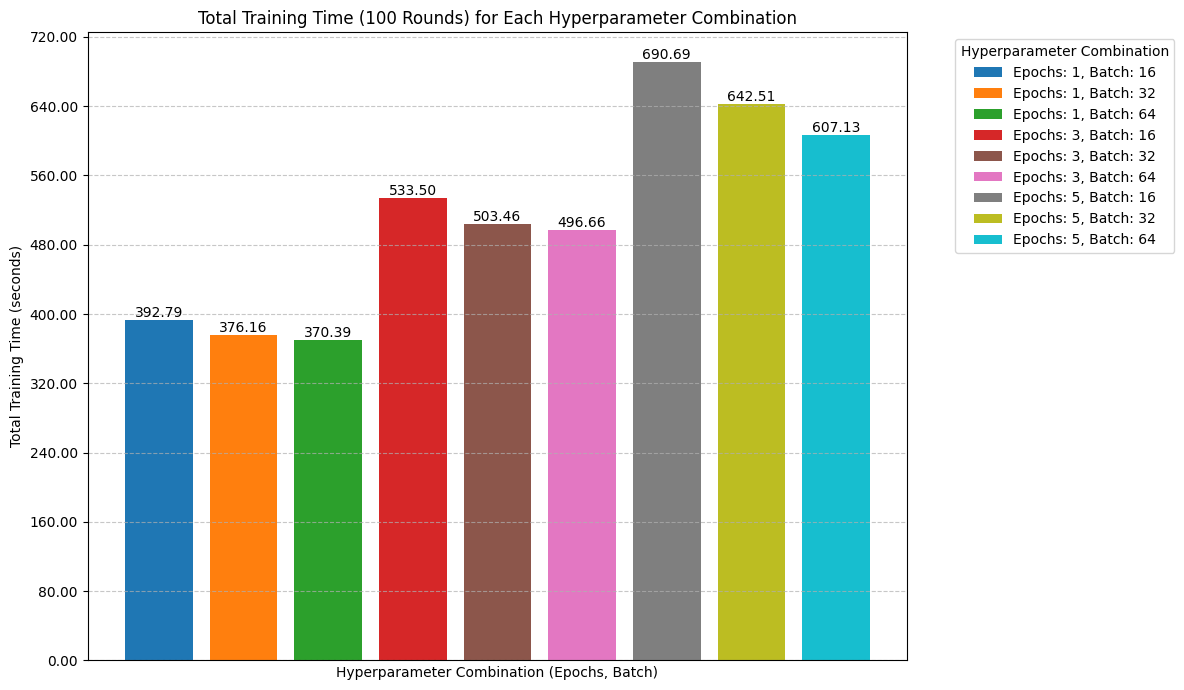

In [59]:
# --- Bar chart for Total Training Time ---
plt.figure(figsize=(12, 7))
ax5 = plt.gca() # Get current axes for the bar chart
labels = []
times = []
for result_entry in tuning_results_list:
    labels.append(f"Epochs: {result_entry['num_epochs']}, Batch: {result_entry['batch_size']}")
    times.append(result_entry['total_training_time_seconds'])

# Generate a color map for the bars
cmap = plt.colormaps.get_cmap('tab10')
colors = [cmap(i) for i in np.linspace(0, 1, len(labels))]


bars = ax5.bar(labels, times, color=colors) # Assign different colors to bars
ax5.set_xlabel('Hyperparameter Combination (Epochs, Batch)')
ax5.set_ylabel('Total Training Time (seconds)')
ax5.set_title('Total Training Time (100 Rounds) for Each Hyperparameter Combination')
ax5.set_xticks([]) # Hide x-axis labels
ax5.grid(axis='y', linestyle='--', alpha=0.7)

# Set more detailed y-axis ticks
ax5.yaxis.set_major_locator(mticker.MaxNLocator(nbins=10)) # Adjust nbins as needed
ax5.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f')) # Format to 2 decimal places

# Add exact value on top of each bar
for bar in bars:
    yval = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2, yval + 0.05, # Position text slightly above the bar
             f'{yval:.2f}', # Format the text to 2 decimal places
             ha='center', va='bottom') # Horizontal and vertical alignment

# Add legend for the bars
ax5.legend(bars, labels, bbox_to_anchor=(1.05, 1), loc='upper left', title="Hyperparameter Combination")

plt.tight_layout()
plt.show()

The observation that `Epochs: 5, Batch: 16` gives the best model performance (highest accuracy, lowest loss) but also has the longest training time is a fundamental trade-off in machine learning, especially pronounced in federated learning. It boils down to how `NUM_EPOCHS` and `BATCH_SIZE` control the amount of local work and the nature of the learning steps:

1. Higher `NUM_EPOCHS` (More Local Training Passes):
    - ***Concept***: `NUM_EPOCHS` defines how many times each client's entire local dataset is fed through its model for training within a single federated round.
    - ***Impact on Time***: When `NUM_EPOCHS = 5`, each client performs 5 full passes over its data. Compared to `NUM_EPOCHS = 1 or 3`, this means significantly more calculations (forward and backward passes) are done on each client device. Since the total training time is a sum of all clients' local computation times across all rounds, more local work directly increases the overall duration

2. Smaller `BATCH_SIZE` (More Frequent, Finer Local Updates):
    - ***Concept***: `BATCH_SIZE` determines how many examples are processed at once to calculate a single gradient update for the model's weights
    - ***Impact on Time***: When `BATCH_SIZE = 16`, a local dataset is divided into many smaller chunks. For example, if a client has 160 examples:
        + With `BATCH_SIZE = 16`, it makes `160/16=10` gradient updates per epoch
        + With `BATCH_SIZE = 64`, it makes `160/64=2.5` gradient updates per epoch\
    Even though each individual update for a small batch might be faster, the total number of updates performed across an epoch (and thus across all epochs and rounds) is much higher with a smaller batch size. Each update involves overhead (calculating gradients, applying updates to weights). Doing more updates, even small ones, accumulates to a longer total training time

The result perfectly illustrate the common scenario where investing more computational effort (more epochs, finer batches) often leads to ***a better-performing model, but at the cost of increased training time***.